
# Trabajo Práctico 2

Dentro de la carpeta de `data/` vamos a poder encontrar 3 datasets:

- Pokemon (Problema de clasificacion Binaria): La intención es tratar de predecir si basada en la información que tenemos podemos estimar si la carta que estamos viendo es Legendaria o no (Booleano).
- Heart Disease (Problema de clasificacion Binaria): A partir de este dataset vamos a tratar de determinar si una persona basado en ciertos datos tiene asociado una enfermedad cardiaca.
- Challenger USA Space Shuttle O-Ring Data Set (Regresion multivariada): En este dataset encontramos información sobre varios despegues del space shuttle, la intención de este problema es tratar de predecir cuanto será la cantidad de O-Rings que fallan dadas las condiciones de despegue.

> Para la presentación de sus trabajos prácticos **Elijan 1 de los 3 datasets**

# Importar librerías

Importar aquellas librerías que serán utilizadas en el trabajo.

In [70]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.linear_model import ElasticNet, ElasticNetCV, LogisticRegression, LogisticRegressionCV, SGDClassifier, SGDRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

RANDOM_STATE = 4646
balance = False # Se explica más abajo

# Cargar datos

Cargar los datos de entrenamiento.

Recordemos que para todos los datasets tenemos el archivo `columns.csv` que contiene el nombre y descripción de cada columna en el mismo orden que van a encontrar los datos.

En los casos de datos con extensión  `*.data` vamos a tener que leerlo utilizando `pd.read_data('myfile.data', sep = ',', header = 0, names = my_cols)`

De esta manera si quisieramos cargar datos por ejemplo de Nasa deberiamos poner algo asi


```python
## Importing python earlier

my_cols = pd.read_csv('./data/nasa_orings/columns.csv').column.values.tolist()

my_data = pd.read_csv('./data/nasa_orings/o-ring-erosion-or-blowby.data',
                       delimiter=',',
                       header=0,
                       names = my_cols
                    )
```

In [71]:
# Cargo el dataset Heart Disease

my_cols = pd.read_csv('./data/heart_disease/columns.csv', sep=";").column.values.tolist()
md = pd.read_csv('./data/heart_disease/processed.cleveland.data', delimiter=',',header=0,names = my_cols)

md.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
1,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
2,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
3,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0
4,56.0,1.0,2.0,120.0,236.0,0.0,0.0,178.0,0.0,0.8,1.0,0.0,3.0,0


# Análisis exploratorio básico y preprocesamiento de los datos

Análisis de los datos para conocer los mismos, ver datos faltantes, decidir cómo tratarlos, ver distribuciones, relaciones, etc. Procesar los datos centrándolos, reescalando, codificando, reduciendo dimensiones, etc. según considere necesario.

Vamos a considerar:

- Para escalar datos: `sklearn.preprocessing.StandardScaler()`
- Para completar valores nulos: `sklearn.impute.SimpleImputer()` [Quickguide](https://scikit-learn.org/stable/modules/impute.html)
- Para reduccion de dimensiones (sobre todo para visualizar los datos): PCA o [T-SNE](https://builtin.com/data-science/tsne-python) (Solo para visualización)
- Para codificar variables categóricas: `sklearn.preprocessing.OneHotEncoder()`

In [72]:
# Analizo cada columna del dataset en búsqueda de datos faltantes y/o anomalías.

# (1) AGE

print(md.age.describe())
print("datos nulos: ", md.age.isnull().sum())

# 302 registros, tipo float64, edades entre 29 y 77 años, no hay datos nulos.

# Pienso que deberian ser enteros. Búsco si hay decimales y luego convierto la columna a integer.

md[md.age.astype('int')>md.age].age.count()

md.age = md.age.astype('int16')


count    302.000000
mean      54.410596
std        9.040163
min       29.000000
25%       48.000000
50%       55.500000
75%       61.000000
max       77.000000
Name: age, dtype: float64
datos nulos:  0


In [73]:
# (2) SEX (1 = male, 0 = female)

print(md.sex.describe())
print("datos nulos: ", md.sex.isnull().sum())

# 302 registros, sin datos nulos, min 0 y max 1, lo convierto a category.

md.sex = md.sex.astype('category')

md.sex.value_counts()


count    302.000000
mean       0.678808
std        0.467709
min        0.000000
25%        0.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: sex, dtype: float64
datos nulos:  0


1.0    205
0.0     97
Name: sex, dtype: int64

In [74]:
# (3) CP chest pain type, Value 1: typical angina, Value 2: atypical angina, Value 3: non-anginal pain, Value 4: asymptomatic

print(md.cp.describe())
print("datos nulos: ", md.cp.isnull().sum())

md.cp.value_counts()

# convierto la columna a category
md.cp = md.cp.astype('category')

count    302.000000
mean       3.165563
std        0.953612
min        1.000000
25%        3.000000
50%        3.000000
75%        4.000000
max        4.000000
Name: cp, dtype: float64
datos nulos:  0


In [75]:
# (4) trestbps resting blood pressure (in mm Hg on admission to the hospital)
# Este parámetro deberá estar entre 60 - 370 (de lo contrario la persona estará muerta o sería un error)

print(md.trestbps.describe())
print("datos nulos: ", md.trestbps.isnull().sum())
md[md.trestbps.astype('int')>md.trestbps].trestbps.count()

# se han almacenado números enteros unicamente por lo tanto cambio el tipo de columna
md.trestbps = md.trestbps.astype('int16')




count    302.000000
mean     131.645695
std       17.612202
min       94.000000
25%      120.000000
50%      130.000000
75%      140.000000
max      200.000000
Name: trestbps, dtype: float64
datos nulos:  0


In [76]:
# (5) chol serum cholestoral in mg/dl
print(md.chol.describe())
print("datos nulos: ", md.chol.isnull().sum())
md[md.chol.astype('int')>md.chol].chol.count()
## IMPORTANTE:
# MENORES DE 19 AÑOS: <170 mg/dL
# MAYOR A 20 AÑOS: 125 a 200 mg/dL
# Siendo toda la población analizada de más de 20 años, se desea un nivel de colesteros de entre 125 a 200 mg/dL.
# dado que no hay valores decimales, lo convierto a entero.

md.chol = md.chol.astype('int16')

count    302.000000
mean     246.738411
std       51.856829
min      126.000000
25%      211.000000
50%      241.500000
75%      275.000000
max      564.000000
Name: chol, dtype: float64
datos nulos:  0


In [77]:
# (6) fbs (fasting blood sugar > 120 mg/dl)  (1 = true, 0 = false)
# Tiene que ver con diabetes, menos de 99 es normal, 100 y 125 indica prediabetes, y mas de 126 diabetes
# Las personas con diabetes  tienen más probabilidades de presentar enfermedades cardiaca. 

print(md.fbs.describe())
print("datos nulos: ", md.fbs.isnull().sum())

print(md.fbs.value_counts())

md.fbs = md.fbs.astype('category')




count    302.000000
mean       0.145695
std        0.353386
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
Name: fbs, dtype: float64
datos nulos:  0
0.0    258
1.0     44
Name: fbs, dtype: int64


In [78]:
# (7) restecg  resting electrocardiographic results, Value 0: normal, Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation 
# or depression of > 0.05 mV), Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria

# El valor 2 indica hipertrofia ventricular detectada por un ECG, lo que ya en sí es una enfermedad cardiaca.

print(md.restecg.describe())
print("datos nulos: ", md.restecg.isnull().sum())
print(md.restecg.value_counts())
md.restecg = md.restecg.astype('category')



count    302.000000
mean       0.986755
std        0.994916
min        0.000000
25%        0.000000
50%        0.500000
75%        2.000000
max        2.000000
Name: restecg, dtype: float64
datos nulos:  0
0.0    151
2.0    147
1.0      4
Name: restecg, dtype: int64


In [79]:
# (8) thalach maximum heart rate achieved

# IMPORTANTE (para implementar una columna más en el data set, aunque se debería tener más información sobre las codiciones en que se midió este dato)
# You can estimate your maximum heart rate based on your age. To estimate your maximum age-related heart rate, subtract your age from 220. 
# For example, for a 50-year-old person, the estimated maximum age-related heart rate would be calculated as 220 – 50 years = 170 beats per minute (bpm).

print(md.thalach.describe())
print("datos nulos: ", md.thalach.isnull().sum())
md.thalach = md.thalach.astype('int16')
md['hr_ref'] = (220-md.age)




count    302.000000
mean     149.605960
std       22.912959
min       71.000000
25%      133.250000
50%      153.000000
75%      166.000000
max      202.000000
Name: thalach, dtype: float64
datos nulos:  0


In [80]:
md[md.hr_ref<md.thalach].head(100)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,hr_ref
2,37,1.0,3.0,130,250,0.0,0.0,187,0.0,3.5,3.0,0.0,3.0,0,183
4,56,1.0,2.0,120,236,0.0,0.0,178,0.0,0.8,1.0,0.0,3.0,0,164
5,62,0.0,4.0,140,268,0.0,2.0,160,0.0,3.6,3.0,2.0,3.0,3,158
14,57,1.0,3.0,150,168,0.0,0.0,174,0.0,1.6,1.0,0.0,3.0,0,163
22,58,1.0,3.0,132,224,0.0,2.0,173,0.0,3.2,1.0,2.0,7.0,3,162
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283,61,1.0,4.0,148,203,0.0,0.0,161,0.0,0.0,1.0,1.0,7.0,2,159
288,56,1.0,2.0,120,240,0.0,0.0,169,0.0,0.0,3.0,0.0,3.0,0,164
290,55,0.0,2.0,132,342,0.0,0.0,166,0.0,1.2,1.0,0.0,3.0,0,165
294,41,1.0,2.0,120,157,0.0,0.0,182,0.0,0.0,1.0,0.0,3.0,0,179


In [81]:
# 66 pesonas tienen un ritmo cardiaco mayor que el correspondiente a su edad.

In [82]:
# (9) exang exercise induced angina (1 = yes, 0 = no)
# Dolor en el pecho tras hacer ejercicio

print(md.exang.describe())
print("datos nulos: ", md.exang.isnull().sum())
print(md.exang.value_counts())
md.exang = md.exang.astype('category')


count    302.000000
mean       0.327815
std        0.470196
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: exang, dtype: float64
datos nulos:  0
0.0    203
1.0     99
Name: exang, dtype: int64


In [83]:
# (10) oldpeak ST depression induced by exercise relative to rest
# El maximo aceptado es 0,5mm

print(md.oldpeak.describe())
print(md.oldpeak.value_counts())

# Parecen ser correctos los valores y tipo de esta columna.

count    302.000000
mean       1.035430
std        1.160723
min        0.000000
25%        0.000000
50%        0.800000
75%        1.600000
max        6.200000
Name: oldpeak, dtype: float64
0.0    99
1.2    17
1.0    14
0.6    14
1.4    13
0.8    13
0.2    12
1.6    11
1.8    10
0.4     9
2.0     9
0.1     7
2.8     6
2.6     6
1.9     5
3.0     5
1.5     5
0.5     5
2.2     4
3.6     4
2.4     3
0.9     3
3.4     3
0.3     3
4.0     3
4.2     2
1.1     2
2.5     2
3.2     2
2.9     1
5.6     1
2.1     1
6.2     1
1.3     1
3.1     1
3.8     1
0.7     1
3.5     1
2.3     1
4.4     1
Name: oldpeak, dtype: int64


In [84]:
# (11) slope the slope of the peak exercise ST segment, Value 1: upsloping, Value 2: flat, Value 3: downsloping
# Flat or downsloping ST depression ≥ 0.5 mm at the J-point in ≥ 2 contiguous leads indicates myocardial ischaemia (according to the 2007 Task Force Criteria).
# Upsloping ST depression in the precordial leads with prominent De Winter T waves is highly specific for occlusion of the LAD.

print("datos nulos: ", md.slope.isnull().sum())
print(md.slope.value_counts())
md.slope = md.slope.astype('category')



datos nulos:  0
1.0    142
2.0    140
3.0     20
Name: slope, dtype: int64


In [85]:
# (12) ca; "number of major vessels (0-3) colored by flouroscopy"
# Mayor número implica mayor riesgo de enfermedad cardiaca

print(md.ca.describe())
print("datos nulos: ", md.ca.isnull().sum())
print(md.ca.value_counts())

# Hay 4 filas que tienen un valor "?", se eliminan las 4 filas.

md = md.drop(md[md.ca == '?'].index)

md.ca = md.ca.astype('category')

count     302
unique      5
top       0.0
freq      175
Name: ca, dtype: object
datos nulos:  0
0.0    175
1.0     65
2.0     38
3.0     20
?        4
Name: ca, dtype: int64


In [86]:
# (13) thal; "3 = normal, 6 = fixed defect, 7 = reversable defect"
# La talasemia es un trastorno sanguíneo hereditario que hace que tu cuerpo tenga menos hemoglobina de lo normal. La hemoglobina permite que los glóbulos rojos transporten oxígeno. 
# La talasemia puede causar anemia, lo que te hace sentir con fatiga. Si tienes talasemia leve, es posible que no necesites tratamiento.
# Las personas con talasemia pueden acumular demasiado hierro debido a su mayor absorción y a las transfusiones sanguíneas frecuentes. El mineral sobrante puede depositarse en el 
# corazón y generar una enfermedad por sobrecarga de hierro, insuficiencia cardíaca o muerte prematura.

print(md.thal.describe())
print("datos nulos: ", md.thal.isnull().sum())
print(md.thal.value_counts())

# Hay 2 filas que tienen un valor "?", se eliminan las 2 filas.

md = md.drop(md[md.thal == '?'].index)

md.thal = md.thal.astype('category')


count     298
unique      4
top       3.0
freq      164
Name: thal, dtype: object
datos nulos:  0
3.0    164
7.0    115
6.0     17
?        2
Name: thal, dtype: int64


In [87]:
# num; diagnosis of heart disease (angiographic disease status), 
# Value 0: < 50% diameter narrowing, 
# Value 1: > 50% diameter narrowing (in any major vessel: attributes 59 through 68 are vessels)

print(md.num.describe())
print("datos nulos: ", md.num.isnull().sum())
print(md.num.value_counts())

# Los valores deberian ser 0 o 1, la columna es muy importante ya que será el target del algoritmo implementado.
# Por lo anterior prefiero eliminar las filas ya que una siposición incorrecta sobre esta columna alterará los resultados del algoritmo.

md[md.num==3].head(100)

md = md.drop(md[md.num == 2].index)
md = md.drop(md[md.num == 3].index)
md = md.drop(md[md.num == 4].index)

md.num = md.num.astype('category')



count    296.000000
mean       0.949324
std        1.235410
min        0.000000
25%        0.000000
50%        0.000000
75%        2.000000
max        4.000000
Name: num, dtype: float64
datos nulos:  0
0    159
1     54
2     35
3     35
4     13
Name: num, dtype: int64


In [88]:
# ELimino 50 registros en forma aleatoria cuyo num = 0

if (balance):
    
    np.random.seed(RANDOM_STATE)
    remove_n = 100
    drop_indices = np.random.choice(md[md.num==0].index, remove_n, replace=False)
    md_removed = md.loc[drop_indices]
    #print(drop_indices)
    md = md.drop(drop_indices)
    md_removed.head()


# 54 (EC)
# 159 (SANO)

In [89]:
# Resetea el indice luego de borrar varias filas
md.reset_index(inplace=True, drop=True)

md.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213 entries, 0 to 212
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   age       213 non-null    int16   
 1   sex       213 non-null    category
 2   cp        213 non-null    category
 3   trestbps  213 non-null    int16   
 4   chol      213 non-null    int16   
 5   fbs       213 non-null    category
 6   restecg   213 non-null    category
 7   thalach   213 non-null    int16   
 8   exang     213 non-null    category
 9   oldpeak   213 non-null    float64 
 10  slope     213 non-null    category
 11  ca        213 non-null    category
 12  thal      213 non-null    category
 13  num       213 non-null    category
 14  hr_ref    213 non-null    int16   
dtypes: category(9), float64(1), int16(5)
memory usage: 7.0 KB


In [90]:
# onehoteecoding

ohe = OneHotEncoder(sparse=False, drop='if_binary') 
a = ohe.fit_transform(md[['sex','cp','fbs','restecg','exang','slope','ca','thal']])
feature_names = ohe.get_feature_names(['sex','cp','fbs','restecg','exang','slope','ca','thal'])
md2 = pd.concat([md.select_dtypes(exclude='object'), pd.DataFrame(a, columns=feature_names).astype(int)], axis=1)
md2 = md2.drop(['sex','cp','fbs','restecg','exang','slope','ca','thal'], axis=1)


In [91]:

# Reordeno las columnas
md3 = md2[np.append(np.delete(md2.columns.values,5), 'num')]
md3.head(20)

,age,trestbps,chol,thalach,oldpeak,hr_ref,sex_1.0,cp_1.0,cp_2.0,cp_3.0,...,slope_2.0,slope_3.0,ca_0.0,ca_1.0,ca_2.0,ca_3.0,thal_3.0,thal_6.0,thal_7.0,num
0,67,120,229,129,2.6,153,1,0,0,0,...,1,0,0,0,1,0,0,0,1,1
1,37,130,250,187,3.5,183,1,0,0,1,...,0,1,1,0,0,0,1,0,0,0
2,41,130,204,172,1.4,179,0,0,1,0,...,0,0,1,0,0,0,1,0,0,0
3,56,120,236,178,0.8,164,1,0,1,0,...,0,0,1,0,0,0,1,0,0,0
4,57,120,354,163,0.6,163,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
5,53,140,203,155,3.1,167,1,0,0,0,...,0,1,1,0,0,0,0,0,1,1
6,57,140,192,148,0.4,163,1,0,0,0,...,1,0,1,0,0,0,0,1,0,0
7,56,140,294,153,1.3,164,0,0,1,0,...,1,0,1,0,0,0,1,0,0,0
8,44,120,263,173,0.0,176,1,0,1,0,...,0,0,1,0,0,0,0,0,1,0
9,52,172,199,162,0.5,168,1,0,0,1,...,0,0,1,0,0,0,0,0,1,0


In [92]:
# Separo las features del target

y_data = md3['num']
X_data = md3.drop('num', axis=1)


Con lo anterior considero que el dataset quedó listo para su análisis.

In [93]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_data)

In [94]:
# ANALISIS DEL DATASET
# Aplico PCA queriendo graficar ... 3 componentes y el color me dice si tiene enfermedad cardica o se encuentra sano.


pca = PCA(n_components=3, random_state=RANDOM_STATE).fit(X_scaled)

#plt.plot(pca.explained_variance_ratio_)
#plt.ylabel('Explained Variance')
#plt.xlabel('Components')
#plt.show()

X_pca = pca.transform(X_scaled)
X_pca.shape

(213, 3)

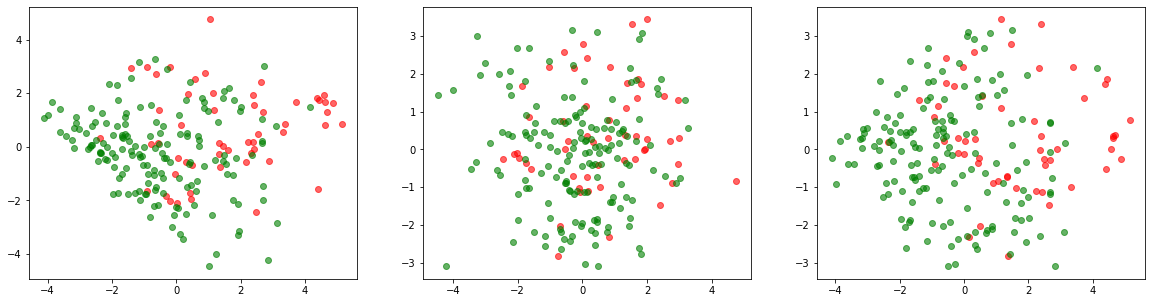

In [95]:

plt.subplots(figsize=(20, 5))
plt.subplot(1, 3, 1)
plt.scatter([X_pca[i,0] for i in range(len(X_pca)) if y_data[i]==1], [X_pca[i,1] for i in range(len(X_pca)) if y_data[i]==1], marker='o', c='red', alpha=0.6)
plt.scatter([X_pca[i,0] for i in range(len(X_pca)) if y_data[i]==0], [X_pca[i,1] for i in range(len(X_pca)) if y_data[i]==0], marker='o', c='green', alpha=0.6)

plt.subplot(1, 3, 2)
plt.scatter([X_pca[i,1] for i in range(len(X_pca)) if y_data[i]==1], [X_pca[i,2] for i in range(len(X_pca)) if y_data[i]==1], marker='o', c='red', alpha=0.6)
plt.scatter([X_pca[i,1] for i in range(len(X_pca)) if y_data[i]==0], [X_pca[i,2] for i in range(len(X_pca)) if y_data[i]==0], marker='o', c='green', alpha=0.6)

plt.subplot(1, 3, 3)
plt.scatter([X_pca[i,0] for i in range(len(X_pca)) if y_data[i]==1], [X_pca[i,2] for i in range(len(X_pca)) if y_data[i]==1], marker='o', c='red', alpha=0.6)
plt.scatter([X_pca[i,0] for i in range(len(X_pca)) if y_data[i]==0], [X_pca[i,2] for i in range(len(X_pca)) if y_data[i]==0], marker='o', c='green', alpha=0.6)

plt.show()

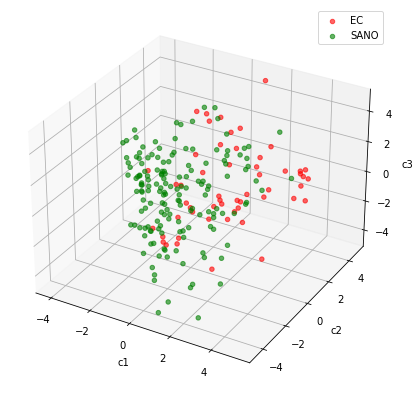

In [96]:

fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")

ax.scatter3D([X_pca[i,0] for i in range(len(X_pca)) if y_data[i]==1], [X_pca[i,1] for i in range(len(X_pca)) if y_data[i]==1], [X_pca[i,1] for i in range(len(X_pca)) if y_data[i]==1], marker='o', c='red', label = 'EC', alpha=0.6)
ax.scatter3D([X_pca[i,0] for i in range(len(X_pca)) if y_data[i]==0], [X_pca[i,1] for i in range(len(X_pca)) if y_data[i]==0], [X_pca[i,1] for i in range(len(X_pca)) if y_data[i]==0], marker='o', c='green', label='SANO', alpha=0.6)

ax.legend(loc=1)

ax.set_xlabel('c1')
ax.set_ylabel('c2')
ax.set_zlabel('c3')

plt.show()


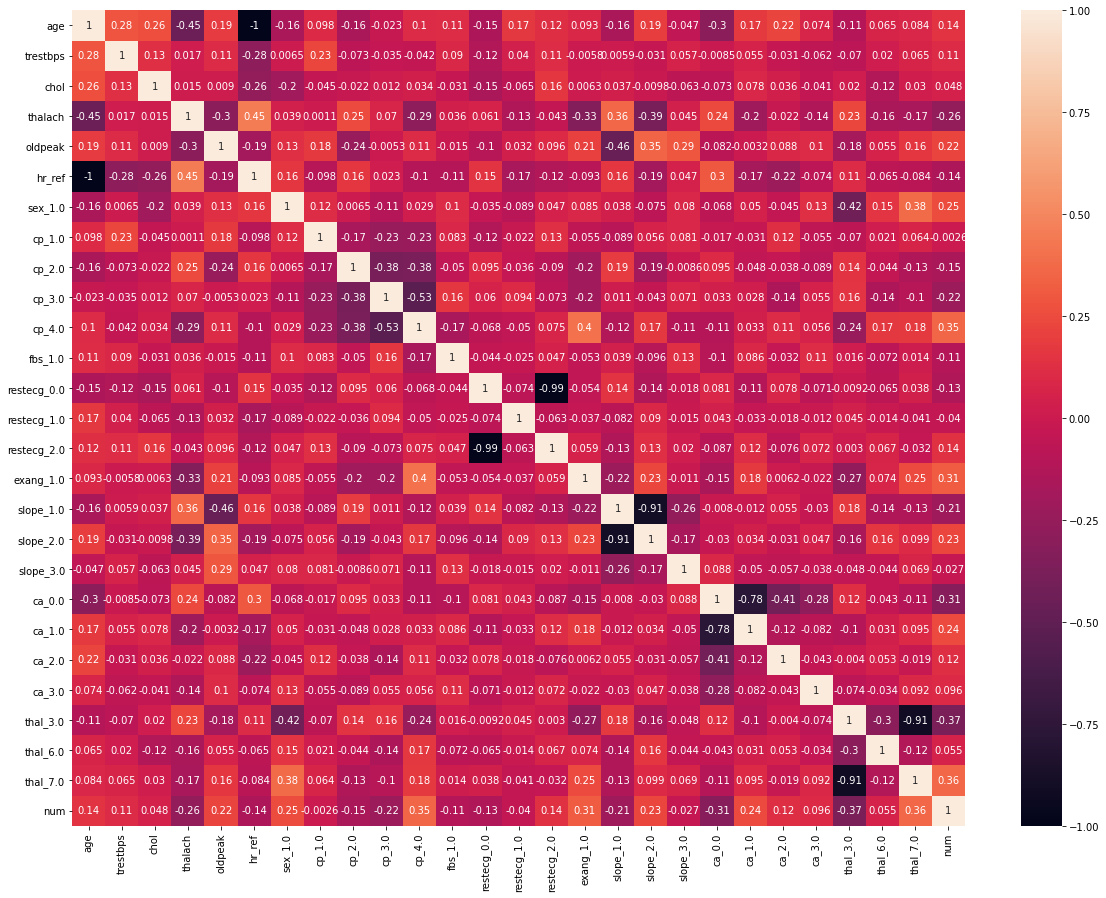

In [97]:
# Busco correlaciones entre los datos . . .
import seaborn as sns

corr = pd.concat( [pd.DataFrame(X_scaled, 
    columns=X_data.columns.values
    ), y_data.astype(int)], axis=1 ).corr(method='pearson')

plt.figure(figsize=(20, 15))
sns.heatmap(corr, annot=True)
plt.show()


Se puede ver cierto grado leve de correlación de los siguientes features CP=4 (+.35), EXANG=1 (+.31), THAL=7 (+.36), CA=0 (-.31), THAL=3 (-.37) con la variable objectivo. El primer parámetro correlacionado "positivamente" es dolor de pecho asintomatico (CP=4), luego EXANG=1, es decir, cuando el ejercicio produce dolor, y por último THAL=7 lo que implica a mi entender, un defecto cardiaco reversible. A su vez, tienen una leve correlación "negativa" sobre la variable target: THAL=3, es decir, ningún defecto cardiaco, y CA=0, lo cual implica (a mi entender nuevamente) ninguna de las venas importantes tapadas.

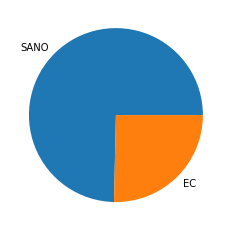

0    159
1     54
Name: num, dtype: int64


In [98]:
# BALANCE ENTRE DATOS. Verifico si hay balance entre los datos, idealmente busco 50% de personas con enfermedad cardico y 50% sin enfermedad cardiaca en mi dataset.

fig, ax = plt.subplots()
ax.pie(y_data.value_counts(), labels=['SANO','EC'])
plt.show()

print(y_data.value_counts())

# Existe mucha diferencia de balance en la variable objetivo. Dado que el dataset tiene muy pocos registros trabajaré sin balancear los datos.
# Entiendo que balancear los datos con un dataset tan chico no sería lo más indicado ya que se reduciria un dataset que ya de por sí es chico. De todas formas implemento una
# variable "balance" que cuando se ejecuta todo el código con su valor en True balancea los datos.

# Modelos y evaluación
Probar diferentes modelos para predecir la variable objetivo. Calcular las métricas que considere relevantes. Comentar los resultados. 

In [99]:
# Separo el dataset en Train y Test

X_data = pd.DataFrame(X_scaled, columns=[X_data.columns.values])

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state = RANDOM_STATE)

print(X_train.shape, X_test.shape)

(170, 26) (43, 26)


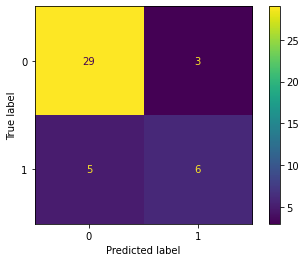

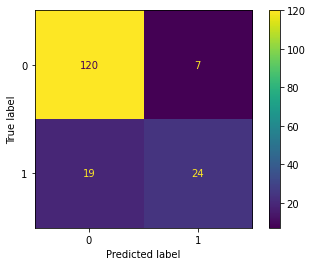

              precision    recall  f1-score   support

           0       0.85      0.91      0.88        32
           1       0.67      0.55      0.60        11

    accuracy                           0.81        43
   macro avg       0.76      0.73      0.74        43
weighted avg       0.81      0.81      0.81        43



In [100]:
# LOGISTIC REGRESSION
lr = LogisticRegression(random_state=RANDOM_STATE)

lr.fit(X_train, y_train)

lr_pred_test = lr.predict(X_test)
lr_pred_train = lr.predict(X_train)
lr_cm_test = confusion_matrix(y_test, lr_pred_test)
lr_cm_train = confusion_matrix(y_train, lr_pred_train)

cmd_test = ConfusionMatrixDisplay(confusion_matrix=lr_cm_test)
cmd_test.plot()
plt.show()

cmd_train = ConfusionMatrixDisplay(confusion_matrix=lr_cm_train)
cmd_train.plot()
plt.show()

print(classification_report(y_test,lr_pred_test))

accuracy = [np.round(lr_cm_test.trace()/lr_cm_test.sum(),2), .0, .0]


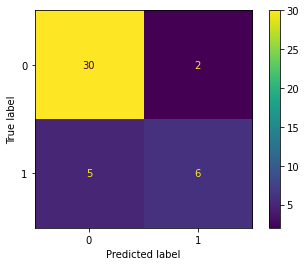

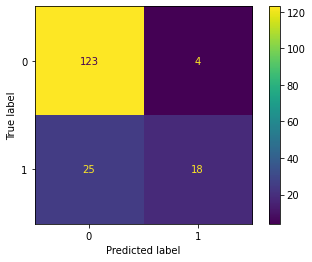

              precision    recall  f1-score   support

           0       0.86      0.94      0.90        32
           1       0.75      0.55      0.63        11

    accuracy                           0.84        43
   macro avg       0.80      0.74      0.76        43
weighted avg       0.83      0.84      0.83        43



In [101]:
# LOGISTIC REGRESSION (CROSS VALIDATION)
lrcv = LogisticRegressionCV(random_state=RANDOM_STATE)

lrcv.fit(X_train, y_train)

lrcv_pred_test = lrcv.predict(X_test)
lrcv_pred_train = lrcv.predict(X_train)
lrcv_pred_test

lrcv_cm_test = confusion_matrix(y_test, lrcv_pred_test)
lrcv_cm_train = confusion_matrix(y_train, lrcv_pred_train)

cmd_test = ConfusionMatrixDisplay(confusion_matrix=lrcv_cm_test)
cmd_test.plot()
plt.show()

cmd_train = ConfusionMatrixDisplay(confusion_matrix=lrcv_cm_train)
cmd_train.plot()
plt.show()

print(classification_report(y_test,lrcv_pred_test))

classification_report(y_test,lrcv_pred_test).find("accuracy")


accuracy[1] = np.round(lrcv_cm_test.trace()/lrcv_cm_test.sum(),2)





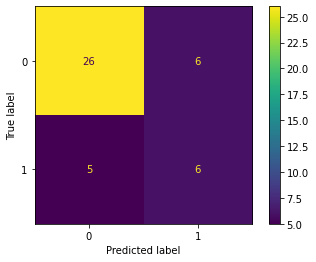

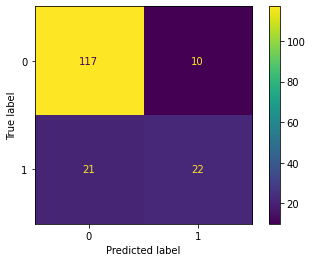

              precision    recall  f1-score   support

           0       0.84      0.81      0.83        32
           1       0.50      0.55      0.52        11

    accuracy                           0.74        43
   macro avg       0.67      0.68      0.67        43
weighted avg       0.75      0.74      0.75        43



In [102]:
# SGD CLASSIFIER
sgdc = SGDClassifier(random_state=RANDOM_STATE)

sgdc.fit(X_train, y_train)

sgdc_pred_test = sgdc.predict(X_test)
sgdc_pred_train = sgdc.predict(X_train)
sgdc_pred_test

sgdc_cm_test = confusion_matrix(y_test, sgdc_pred_test)
sgdc_cm_train = confusion_matrix(y_train, sgdc_pred_train)

cmd_test = ConfusionMatrixDisplay(confusion_matrix=sgdc_cm_test)
cmd_test.plot()
plt.show()

cmd_train = ConfusionMatrixDisplay(confusion_matrix=sgdc_cm_train)
cmd_train.plot()
plt.show()

print(classification_report(y_test,sgdc_pred_test))

accuracy[2] = np.round(sgdc_cm_test.trace()/sgdc_cm_test.sum(),2)

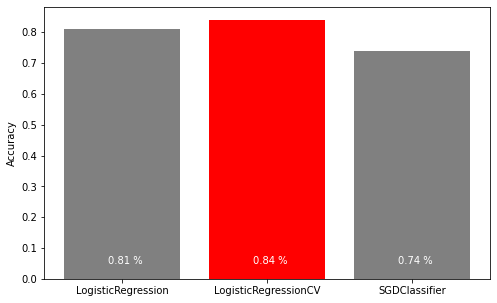

In [103]:
color = ['gray','red','gray']
algoritmos = ['LogisticRegression','LogisticRegressionCV','SGDClassifier']
plt.figure(figsize=(8,5))
plt.ylabel("Accuracy")
plt.bar(algoritmos, accuracy, color = color)
for i, v in enumerate(algoritmos):
    plt.text(i-.1, 
              .05, 
              str(accuracy[i])+" %", 
              fontsize=10, 
              color='white')
plt.show()

De los clasificadores sugeridos y probados, el que mostro mejor precisión es el de Logistic Regression con Cross Validation. Con una precisión (accuracy) de 84% con los datos de TEST. Se probó también balanceando los datos acorde a la variable target (balance = False). En este último caso LogisticRegressionCV solo obtuvo un 70% de presición (entendiendo que es un algoritmo que se perjudica mucho más que los otros con la reducción del dataset). Con el dataset balanceado, el valor más alto de presición lo obtuvo LogisticRegression con un 91%. Nuevamente, no son valores en los cuales se deba confiar mucho debido al reducido tamaño del dataset.